In [19]:
import os
import numpy as np
import pandas as pd
import pywt
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

def load_data(directory):
    """Load and pair EOG signals from directory with class folders containing h/v files"""
    data = []
    
    class_folders = {
        'Blink': 'blink',
        'Down': 'down',
        'Left': 'left',
        'Right': 'right',
        'Up': 'up'
    }
    
    for class_folder, label in class_folders.items():
        class_path = os.path.join(directory, class_folder)
        
        if not os.path.exists(class_path):
            continue
            
        file_pairs = {}
        
        for filename in os.listdir(class_path):
            if filename.endswith(('h.txt', 'v.txt')):
                try:
                    file_num = filename.split('.')[0][:-1]
                    suffix = filename[-5]
                    if file_num not in file_pairs:
                        file_pairs[file_num] = {}
                    file_pairs[file_num][suffix] = os.path.join(class_path, filename)
                except:
                    continue
        
        for file_num, files in file_pairs.items():
            if 'h' in files and 'v' in files:
                try:
                    h_signal = np.loadtxt(files['h'])
                    v_signal = np.loadtxt(files['v'])
                    data.append((h_signal, v_signal, label))
                except:
                    continue
    
    return data

def preprocess_signal(signal, fs=176):
    # Bandpass filter (0.5-20 Hz)
    nyq = 0.5 * fs
    low = 0.5 / nyq
    high = 20 / nyq
    b, a = butter(4, [low, high], btype='band')
    filtered = filtfilt(b, a, signal)
    
    # Normalize
    scaler = MinMaxScaler()
    normalized = scaler.fit_transform(filtered.reshape(-1, 1)).flatten()
    
    return normalized

def extract_raw_features(signal):
    return [
        np.mean(signal),
        np.std(signal),
        np.min(signal),
        np.max(signal),
        np.median(signal),
        np.sum(signal**2),  # Energy
    ]

def extract_wavelet_features(signal):
    features = []
    coeffs = pywt.wavedec(signal, 'db4', level=2)
    features.extend(coeffs[0][:])  
    return features

def create_features(preprocessed_data, feature_type='wavelet'):
    """
    Create feature matrix from preprocessed signals.
    'raw' - only statistical features
    'wavelet' - only wavelet features
    """
    X = []
    y = []
    
    for h_signal, v_signal, label in preprocessed_data:
        if feature_type == 'raw':
            h_features = extract_raw_features(h_signal)
            v_features = extract_raw_features(v_signal)
        elif feature_type == 'wavelet':
            h_features = extract_wavelet_features(h_signal)
            v_features = extract_wavelet_features(v_signal)
        
        features = h_features + v_features  
        X.append(features)
        y.append(label)
    
    return np.array(X), np.array(y)

def preprocess_dataset(dataset):
    preprocessed = []
    for h, v, label in dataset:
        h_processed = preprocess_signal(h)
        v_processed = preprocess_signal(v)
        preprocessed.append((h_processed, v_processed, label))
    return preprocessed

def train_and_evaluate(X_train, X_test, y_train, y_test):
    """Train SVM and return evaluation metrics"""
    svm = SVC(kernel='rbf', C=1, gamma=0.05)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, precision, recall, f1, cm

def create_signal_df(data, label='Class'):
    records = []
    for h, v, the_class in data:
        combined = np.concatenate([h, v])
        records.append(np.append(combined, the_class))
    col_names = [f"sample_{i+1}" for i in range(2 * len(data[0][0]))] + [label]
    return pd.DataFrame(records, columns=col_names)


In [ ]:

train_data = load_data("data/train")
test_data = load_data("data/test")

train_raw_df = create_signal_df(train_data)
test_raw_df = create_signal_df(test_data)

# Save and display
train_raw_df.to_csv("saved_csv_data/train/train_raw_signals.csv", index=False)
test_raw_df.to_csv("saved_csv_data/test/test_raw_signals.csv", index=False)

train_raw_df

,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,sample_10,...,sample_492,sample_493,sample_494,sample_495,sample_496,sample_497,sample_498,sample_499,sample_500,Class
0,135.0,128.0,128.0,134.0,131.0,128.0,131.0,136.0,127.0,132.0,...,142.0,125.0,127.0,131.0,132.0,128.0,132.0,134.0,134.0,blink
1,142.0,136.0,137.0,142.0,141.0,134.0,144.0,143.0,134.0,139.0,...,130.0,127.0,131.0,124.0,127.0,136.0,128.0,131.0,135.0,blink
2,132.0,130.0,123.0,130.0,132.0,124.0,131.0,132.0,125.0,127.0,...,131.0,131.0,134.0,126.0,119.0,124.0,120.0,129.0,128.0,blink
3,129.0,120.0,128.0,129.0,121.0,127.0,131.0,124.0,124.0,131.0,...,131.0,120.0,129.0,120.0,128.0,124.0,129.0,129.0,131.0,blink
4,130.0,138.0,134.0,129.0,135.0,140.0,128.0,135.0,137.0,133.0,...,132.0,132.0,130.0,131.0,131.0,125.0,131.0,121.0,129.0,blink
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,161.0,163.0,164.0,158.0,161.0,162.0,160.0,161.0,166.0,162.0,...,124.0,126.0,126.0,130.0,117.0,123.0,127.0,122.0,123.0,up
76,143.0,136.0,136.0,141.0,137.0,141.0,141.0,140.0,136.0,141.0,...,140.0,124.0,138.0,138.0,131.0,137.0,138.0,129.0,131.0,up
77,152.0,158.0,148.0,152.0,156.0,153.0,151.0,154.0,154.0,153.0,...,127.0,128.0,123.0,124.0,125.0,129.0,127.0,124.0,128.0,up
78,146.0,145.0,144.0,147.0,143.0,143.0,146.0,142.0,142.0,147.0,...,135.0,139.0,145.0,144.0,140.0,141.0,140.0,136.0,142.0,up


In [21]:
train_data_processed = preprocess_dataset(train_data)
test_data_processed = preprocess_dataset(test_data)

# === 2. Preprocessed signal DataFrame ===
train_preprocessed_df = create_signal_df(train_data_processed)
test_preprocessed_df = create_signal_df(test_data_processed)

# Save and display
train_preprocessed_df.to_csv("saved_csv_data/train/train_preprocessed_signals.csv", index=False)
test_preprocessed_df.to_csv("saved_csv_data/test/test_preprocessed_signals.csv", index=False)
train_preprocessed_df

,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,sample_10,...,sample_492,sample_493,sample_494,sample_495,sample_496,sample_497,sample_498,sample_499,sample_500,Class
0,0.11213271124364532,0.06464643973682879,0.027175667013359786,0.005611752387917751,0.0,0.005734749749441409,0.01641970783093749,0.02672351635649224,0.034059276228044805,0.03863242676368593,...,0.3716963142167799,0.2521033191851018,0.12725823348368315,0.037585129175419285,0.01322919614311513,0.06497843960112887,0.1852816883114924,0.3547827402134319,0.5491311663814453,blink
1,0.15119846097458178,0.11189432469185503,0.08338077629849748,0.0713099694838555,0.07404074076526207,0.08413734233770723,0.09225193008882235,0.09134426680142774,0.07942467027032357,0.05980569496034034,...,0.035181112838141015,0.01829793802158519,0.003366060371920554,0.0,0.020704848717310043,0.07514761375478385,0.16626419359521272,0.2886411121810402,0.4289585935969002,blink
2,0.10608066855201116,0.061370360969941765,0.026164878529983907,0.005841467120589111,0.0,0.003825527167773929,0.011163812462884865,0.017336224303963935,0.02037667047304889,0.02054793649255318,...,0.8690070098957856,0.7583967755965573,0.5833331551730083,0.3814410914241908,0.2134661432310982,0.14094403714340192,0.19964416924029682,0.38261373390198805,0.6406444948442404,blink
3,0.08569840599877261,0.04890789901474596,0.019956761907945098,0.0035741313974679556,0.0,0.005860118779957457,0.01634800797997077,0.027361459892289663,0.036573202285830025,0.04328473423792581,...,0.24752100232234375,0.1137264589057404,0.02505438446520647,0.0,0.041319601489046565,0.13904553616576754,0.2767412439624908,0.4377625674651872,0.6087623682173129,blink
4,0.02494861231895805,0.06145874468847136,0.09110475668950192,0.1097456296730531,0.11709704349436065,0.1160543094238797,0.11099803173120952,0.10595076602138813,0.10324159243052079,0.10310927904388288,...,0.5875835143654832,0.6314457778483382,0.6159183857996496,0.5424663313568632,0.44186284590360775,0.3601946717825194,0.3366767877127522,0.383344540417875,0.47739217482915625,blink
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.3026093207314126,0.301483341397745,0.2997332567149072,0.2976938644206156,0.2966657331106856,0.29790598967093596,0.3015865885710597,0.30664675389442975,0.3117174471775706,0.3164642806517634,...,0.6913219449632704,0.6980668510162866,0.6859522230427759,0.6580919140046851,0.6246709402107472,0.5973480251434082,0.5835154258660963,0.5836805770569856,0.5924615761772796,up
76,0.1727380948049173,0.13414986824041508,0.10433089500646345,0.08813679379812042,0.08493383011294128,0.09001377608858033,0.0976756321533499,0.10393450028726256,0.10748506035747912,0.10890795245490639,...,0.7578596903512278,0.7514447391739052,0.7782647162129678,0.8216635500675219,0.8555840652762878,0.8545918477528476,0.8040389744884718,0.7061467584010516,0.5796679017557289,up
77,0.29601442972748193,0.3006921001334895,0.30474487366656183,0.30780352550311574,0.30988150775825907,0.31132672862651445,0.3126124934907252,0.31396941890190105,0.315050663184525,0.314916237956681,...,0.31875849245870014,0.30045118548956523,0.2750587623244474,0.2558760399736983,0.25563617605252165,0.2809844173426803,0.3315392546367393,0.40168768320413617,0.4824772393271613,up
78,0.12732388031773728,0.11740744828556486,0.10718001778435234,0.09686335204766133,0.08752327936193569,0.08096009890711836,0.07905288509186076,0.08275705912874087,0.09125014230948664,0.10181012320203289,...,0.196462296380781,0.3249475545468148,0.420075066141392,0.45938998165565836,0.4496815815773712,0.4219553319021555,0.4124502424255713,0.4407011434163976,0.49831741588850376,up


In [22]:
feature_types = ['raw', 'wavelet']
results = []
confusion_matrices = {}

for feature_type in feature_types:
    print(f"\nProcessing with {feature_type} features...")

    X_train, y_train = create_features(train_data_processed, feature_type)
    X_test, y_test = create_features(test_data_processed, feature_type)
    # Create and save feature DataFrame
    feature_col_names = [f"f_{i}" for i in range(X_train.shape[1])] + ['Class']
    train_features_df = pd.DataFrame(np.column_stack([X_train, y_train]), columns=feature_col_names)
    test_features_df = pd.DataFrame(np.column_stack([X_test, y_test]), columns=feature_col_names)

    train_features_df.to_csv(f"saved_csv_data/train/train_features_{feature_type}.csv", index=False)
    test_features_df.to_csv(f"saved_csv_data/test/test_features_{feature_type}.csv", index=False)

    display(train_features_df)

    # Encode labels
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)
    class_names = le.classes_
    # Train and evaluate
    accuracy, precision, recall, f1, cm = train_and_evaluate(X_train, X_test, y_train_encoded, y_test_encoded)
    
    results.append({
        'Feature Type': feature_type,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    confusion_matrices[feature_type] = (cm, class_names)





Processing with raw features...


,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,Class
0,0.13157785133295904,0.14079686996766952,0.0,1.0,0.0996299729338186,9.284122388522777,0.5495980310218527,0.21632147446678882,0.0,1.0,0.5626309895581928,87.21324400464573,blink
1,0.11608762562529656,0.1389789630841386,0.0,0.9999999999999999,0.08786207846423247,8.197872250815342,0.4647076630674013,0.2790782140809311,0.0,1.0,0.38985381843613126,73.45946542204183,blink
2,0.1272516564294544,0.14761282322207606,0.0,1.0000000000000002,0.105829850512279,9.495632410907946,0.5640381403820198,0.2360498245419288,0.0,1.0,0.5760508892207671,93.46463586797061,blink
3,0.18982968546623044,0.14247291964655545,0.0,1.0,0.17109802430638127,14.083460579205457,0.6216974855201692,0.18546672281414026,0.0,1.0,0.647056888757682,105.22641719337955,blink
4,0.09954772729825744,0.1487856616852075,0.0,1.0,0.06870227341167556,8.011730783338313,0.4948063245995559,0.1804555557279264,0.0,1.0,0.48611484711458697,69.34937661419897,blink
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.3497337221471781,0.25883794986273767,0.0,1.0,0.2915418392241219,47.32769017401618,0.6134086862680961,0.19923688388134064,0.0,1.0,0.6292254086581339,103.9913880719746,up
76,0.2521046471581745,0.27240542323209327,0.0,1.0,0.1323382123982078,34.44036693125088,0.6133946687028909,0.18517271205618957,0.0,1.0,0.6504229582736434,102.63548822084346,up
77,0.3403360050071211,0.22970589005602934,0.0,1.0,0.2860756188336593,42.14834805765995,0.4833798499370831,0.2265082259287861,0.0,1.0,0.47272993557307375,71.24051393465075,up
78,0.21181699351838262,0.2795938479285568,0.0,1.0,0.10061487902950722,30.75978963566588,0.4782460721035495,0.21885181252618183,0.0,1.0,0.46651767737943695,69.15385533211713,up



Processing with wavelet features...


,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_125,f_126,f_127,f_128,f_129,f_130,f_131,f_132,f_133,Class
0,0.052248519807625966,0.16550599824708312,-0.020717725070090242,0.12557349714141636,0.10162622013552958,0.023297744469590088,0.07457320263561451,0.11531323600520899,0.10476879801518764,0.08692187365496397,...,1.0175495729207262,1.350953843812527,0.8535324299278848,0.9362901851911705,1.2243684366840442,1.0552526885052875,0.6344902940768031,0.06283885170823592,1.1132818140581537,blink
1,0.1762942481523943,0.25162456222954194,0.12893545601795106,0.22786698469104733,0.2012565820952452,0.1852014203544924,0.0995121628710001,0.06909595032170389,0.11294060419486959,0.019206659356459488,...,0.6965691513962311,0.6550514751292609,0.3227156089893283,0.4908316941046954,0.9450684555929685,0.38872774752132955,0.05331576141768767,0.04918440221246154,0.8614514263857386,blink
2,0.04959244798474618,0.15705133362330329,-0.019530528901802385,0.11881774363745475,0.09776342218035237,0.0178590969635856,0.03887669637280881,0.025065191179975507,0.017328408686055417,0.07724837050748845,...,0.775683949915419,1.3479498781400754,1.7013783059477614,1.7465603031820982,1.441439555436081,1.6594557033480308,1.6751296291637723,0.39465064408144546,1.281872923734624,blink
3,0.039408523548020706,0.12560744494044798,-0.01612236411266188,0.09559641547933866,0.07572183141738618,0.02131676425206807,0.08617195991009019,0.1006725727257993,0.12305297443754674,0.13461792597361022,...,1.432160320110052,1.3439107869874354,0.9063165199403982,1.0387207383391648,0.8442498052895395,1.2121034656570036,0.407945586151355,0.1304846218857983,1.2328397507765387,blink
4,0.1884370331136635,0.09414275880289075,0.2495210654451871,0.1285835486248968,0.1441977512456339,0.22237493585582116,0.21031059726666715,0.2002293291074494,0.19860877232397978,0.14482666202268868,...,1.6837743051681004,1.0881882758959411,1.1775621609475717,1.3541650413032416,1.4597855295919222,0.9276797969711218,1.2247881208274405,0.8223098354953163,0.941353181191974,blink
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.5977638226319291,0.6039956494607966,0.5932484441359364,0.6017231126987332,0.5994417713338964,0.6008216048132786,0.6227812486067412,0.757950939830249,0.8866246529679724,0.8531934667003739,...,1.1309763668607005,1.1713933056330204,1.2827388843894547,1.4433737399835043,1.489105633673428,1.3079686114271027,1.3893203916269512,1.238198035267998,1.1828529069153495,up
76,0.20911819815591345,0.29735872656796064,0.15260952348923146,0.26663340119105783,0.24710448387680928,0.1877101346006782,0.2190290754163916,0.20131935750370517,0.17535374411578236,0.21009651987023584,...,1.336116040166424,1.4839646655750587,1.4136626155059253,1.3532951383159668,1.792387986456362,1.9076722726292776,1.5376573881347384,1.7243744642578793,1.1595613762668133,up
77,0.6119905784927323,0.5973367645574849,0.6215564458353308,0.6032021288653462,0.6034022183131432,0.6227744324265632,0.6315986307806266,0.5709221615538906,0.5654425177664918,0.5850860164848516,...,1.1464079179105624,1.4262841732212679,0.9070051239500101,0.518367260124064,0.632319899388518,0.6517528981065377,0.6098607291064604,0.5200728733530382,0.9688790050763162,up
78,0.20153903284058777,0.24482809808196243,0.17262489962575348,0.22635417372924926,0.22934891630319856,0.1604562345997611,0.2107037196042577,0.20889630676376741,0.20181907704584076,0.18108085056990367,...,0.09474146035595338,0.539966934845972,0.9527281925100477,0.4885737672184416,0.6471235690651036,0.05612573386210117,0.49513173092358675,0.8351881626981617,0.9786322491681628,up


In [23]:
# Display results
results_df = pd.DataFrame(results)
print("\nFinal Results:")
print(results_df.to_string(index=False))

# Determine best feature type
best_result = results_df.loc[results_df['Accuracy'].idxmax()]
print(f"\nBest feature type: {best_result['Feature Type']} with accuracy {best_result['Accuracy']:.4f}")


Final Results:
Feature Type  Accuracy  Precision  Recall  F1 Score
         raw      0.85   0.914286    0.85  0.850216
     wavelet      0.95   0.960000    0.95  0.949206

Best feature type: wavelet with accuracy 0.9500


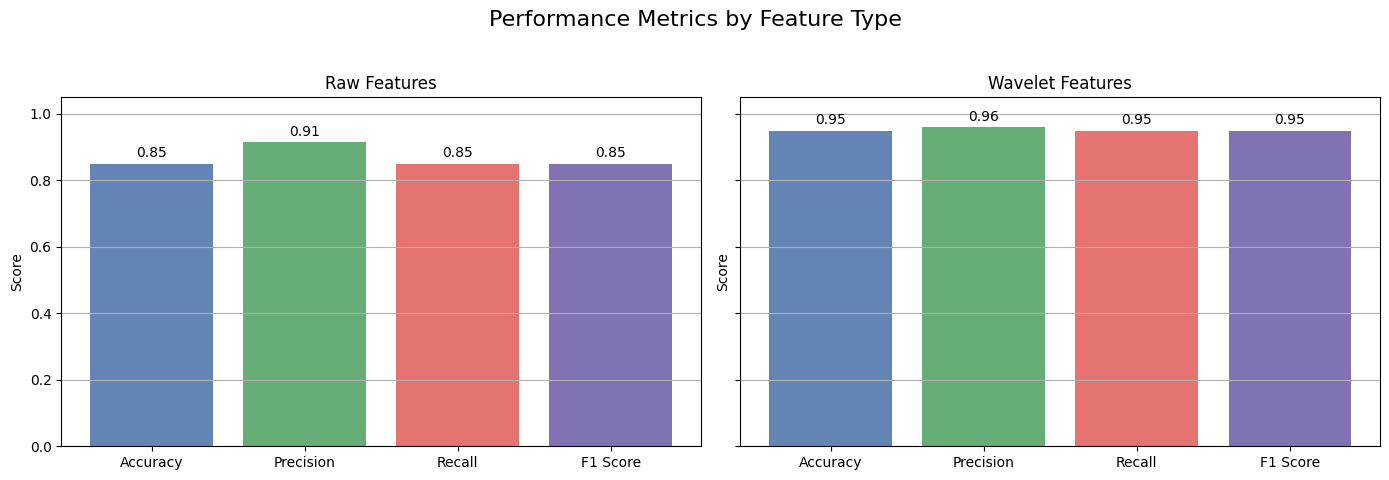

In [24]:
# Plot separate bar charts for raw and wavelet features
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
feature_types = results_df['Feature Type'].tolist()

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for idx, feature in enumerate(feature_types):
    values = results_df.loc[results_df['Feature Type'] == feature, metrics].values.flatten()
    
    axes[idx].bar(metrics, values, color=["#6584b6", "#67ad78", "#e5736f", '#8172b3'])
    axes[idx].set_title(f'{feature.capitalize()} Features')
    axes[idx].set_ylim(0, 1.05)
    axes[idx].set_ylabel('Score')
    axes[idx].grid(axis='y')
    for i, v in enumerate(values):
        axes[idx].text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=10)

plt.suptitle('Performance Metrics by Feature Type', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


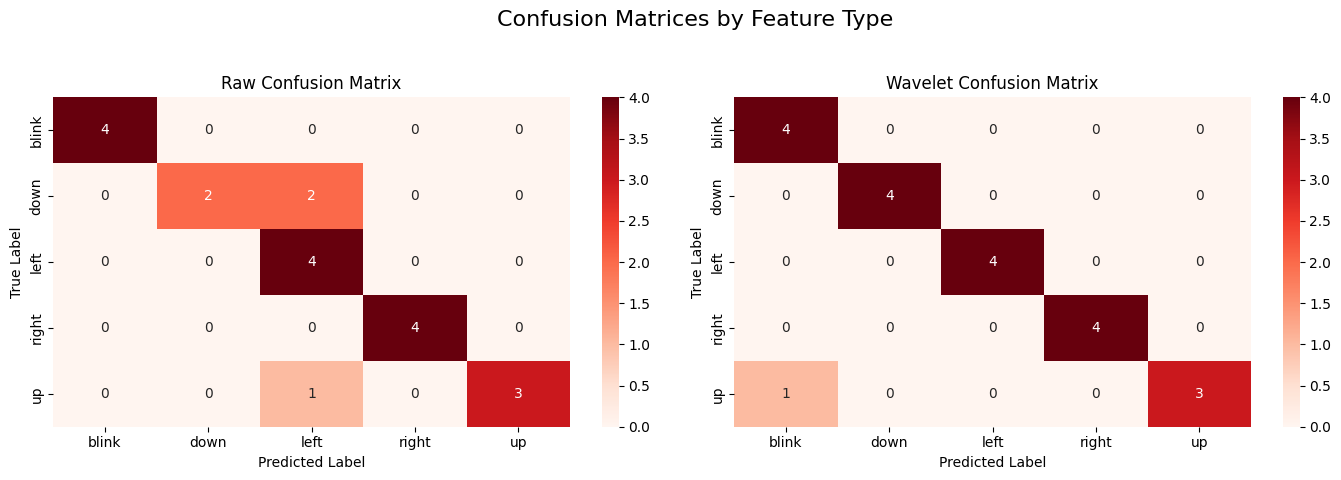

In [25]:
import seaborn as sns

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, feature in enumerate(feature_types):
    cm, class_names = confusion_matrices[feature]
    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", 
                xticklabels=class_names, yticklabels=class_names, ax=axes[idx])
    axes[idx].set_title(f"{feature.capitalize()} Confusion Matrix")
    axes[idx].set_xlabel("Predicted Label")
    axes[idx].set_ylabel("True Label")

plt.suptitle("Confusion Matrices by Feature Type", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [26]:
def plot_eog_sample(h_signal=np.zeros(250), v_signal =np.zeros(250),h2_signal=np.zeros(250), v2_signal=np.zeros(250) , label="", first_title="Sample",second_title="Sample"):

    fig, axes = plt.subplots(2, 1, figsize=(12, 4), sharex=True)

    axes[0].plot(h_signal, color='blue')
    axes[0].plot(v_signal, color='red')
    axes[0].set_title(f"{first_title}  (Label: {label})")
    axes[0].set_ylabel("Amplitude")
    axes[0].grid(True)

    axes[1].plot(h2_signal, color='green')
    axes[1].plot(v2_signal, color='red')
    axes[1].set_title(f"{second_title}  (Label: {label})")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("Amplitude")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

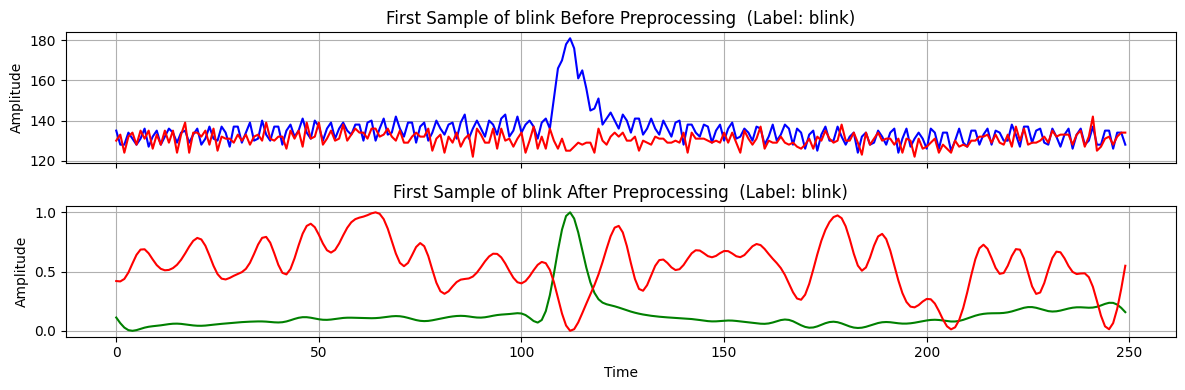

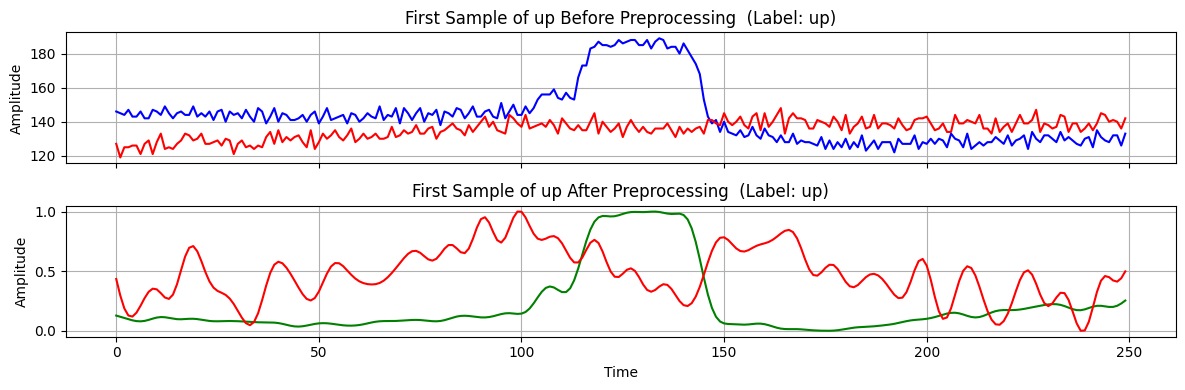

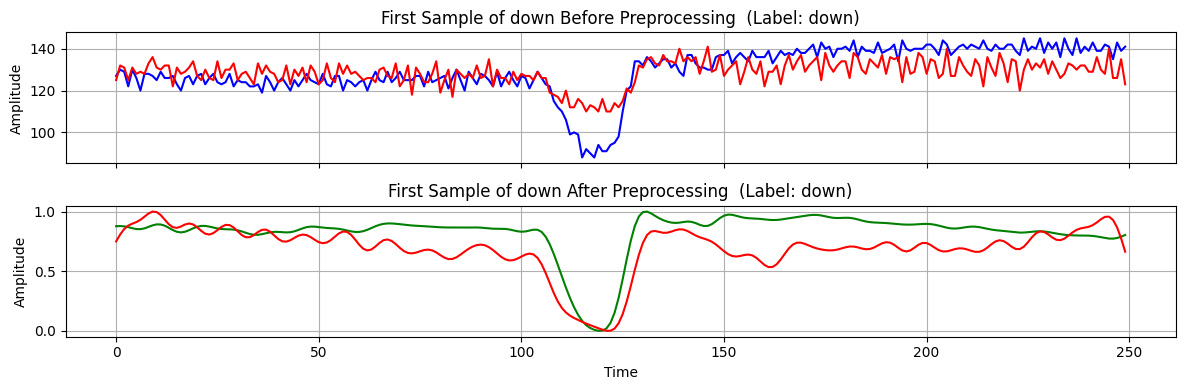

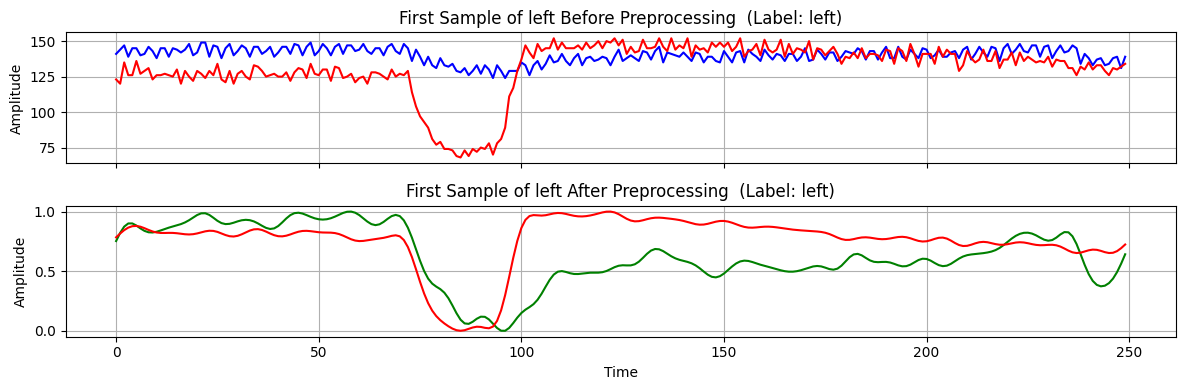

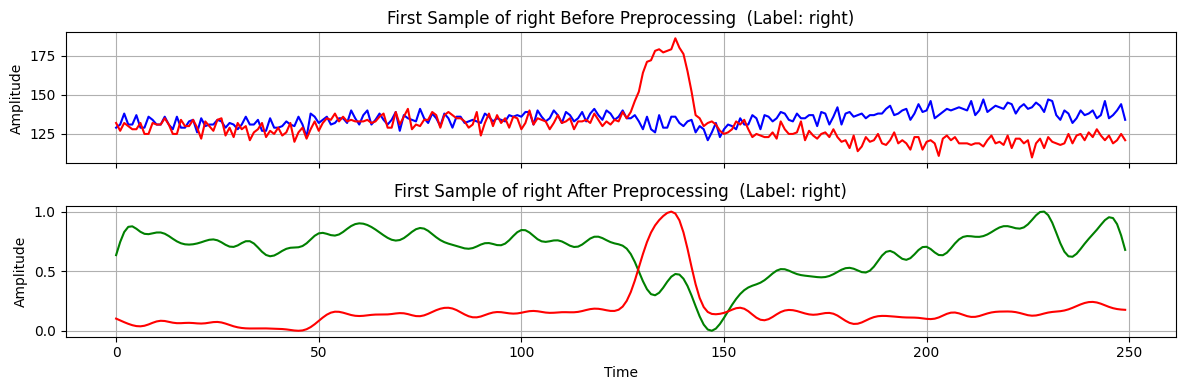

In [27]:
plot_eog_sample(
    h_signal=train_data[0][0],
    v_signal=train_data[0][1],
    h2_signal=train_data_processed[0][0],
    v2_signal=train_data_processed[0][1],
    label=train_data[0][2],
    first_title=f"First Sample of {train_data[0][2]} Before Preprocessing",
    second_title=f"First Sample of {train_data_processed[0][2]} After Preprocessing"
)
plot_eog_sample(
    h_signal=train_data[78][0],
    v_signal=train_data[78][1],
    h2_signal=train_data_processed[78][0],
    v2_signal=train_data_processed[78][1],
    label=train_data[78][2],
    first_title=f"First Sample of {train_data[78][2]} Before Preprocessing",
    second_title=f"First Sample of {train_data_processed[78][2]} After Preprocessing"
)
plot_eog_sample(
    h_signal=train_data[20][0],
    v_signal=train_data[20][1],
    h2_signal=train_data_processed[20][0],
    v2_signal=train_data_processed[20][1],
    label=train_data[20][2],
    first_title=f"First Sample of {train_data[20][2]} Before Preprocessing",
    second_title=f"First Sample of {train_data_processed[20][2]} After Preprocessing"
)
plot_eog_sample(
    h_signal=train_data[40][0],
    v_signal=train_data[40][1],
    h2_signal=train_data_processed[40][0],
    v2_signal=train_data_processed[40][1],
    label=train_data[40][2],
    first_title=f"First Sample of {train_data[40][2]} Before Preprocessing",
    second_title=f"First Sample of {train_data_processed[40][2]} After Preprocessing"
)
plot_eog_sample(
    h_signal=train_data[60][0],
    v_signal=train_data[60][1],
    h2_signal=train_data_processed[60][0],
    v2_signal=train_data_processed[60][1],
    label=train_data[60][2],
    first_title=f"First Sample of {train_data[60][2]} Before Preprocessing",
    second_title=f"First Sample of {train_data_processed[60][2]} After Preprocessing"
)
